In [1]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [2]:
%cd /home/pengyu.zhang/project/superres/ProbSR/Experiment3

/home/pengyu.zhang/project/superres/ProbSR/Experiment3


In [3]:
from data_generation import *
from scipy.linalg import sqrtm
from downscaling import *
from utils import *
import time
import random

In [4]:
%cd Bicubic_Downsampling

/home/pengyu.zhang/project/superres/ProbSR/Experiment3/Bicubic_Downsampling


### Upscale by 4

In [5]:
N_low = 16
N_high = 64
scale = 4
a, b, c, d = 1,1,1,0

h_low = 1/(N_low-1)
x_low = np.arange(0,1.0001,h_low)
y_low = np.arange(0,1.0001,h_low)
z_low = np.arange(0,1.0001,h_low)

h_high = 1/(N_high-1)
x_high = np.arange(0,1.0001,h_high)
y_high = np.arange(0,1.0001,h_high)
z_high = np.arange(0,1.0001,h_high)

In [6]:
w_low, r_low, A_low, x_low, y_low, z_low = generate_data(N_low,a,b,c,d)
w_high, r_high, A_high, x_high, y_high, z_high = generate_data(N_high,a,b,c,d)

/home/pengyu.zhang/project/superres/ProbSR/Experiment3/data_generation.py:131: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  w = linalg.spsolve(A,r).reshape((N,N,N))


In [7]:
'''N_high = 160
A = create_A(N_high)
        
# Work out the forcing term r
r = create_forcing_term(N_high,a,b,c,d)

A_sparse = csr_matrix(A)

startTime = time.time()
w = linalg.spsolve(A_sparse,r).reshape((N_high,N_high))
endTime = time.time()
print(endTime-startTime)

startTime = time.time()
result = A_sparse.dot(r)
endTime = time.time()
print(endTime-startTime)'''

'N_high = 160\nA = create_A(N_high)\n        \n# Work out the forcing term r\nr = create_forcing_term(N_high,a,b,c,d)\n\nA_sparse = csr_matrix(A)\n\nstartTime = time.time()\nw = linalg.spsolve(A_sparse,r).reshape((N_high,N_high))\nendTime = time.time()\nprint(endTime-startTime)\n\nstartTime = time.time()\nresult = A_sparse.dot(r)\nendTime = time.time()\nprint(endTime-startTime)'

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for prior variance
prior_sigma = 0.0001
ll_sigma = 0.0001

In [9]:
operator = (A_high.T) * (1/prior_sigma**2)
b_high = create_forcing_term(N_high,a,b,c,d)

In [31]:
# G = ResidualLearning().to(device)
G = U_net(1,1).to(device)
G.load_state_dict(torch.load('/home/pengyu.zhang/project/superres/ProbSR/Experiment3/Bicubic_Downsampling/models/model3/16_64_unet/lr0.001_gamma0.5_stepsize100_K2000_llsigma_0.0001_psigma_0.0001/ckpt/current_epoch.pth')['netG'])
# G.load_state_dict(torch.load('models/residual_from_low/21_81/lr0.01_gamma0.5/ckpt/best_model.pth')['netG'])

<All keys matched successfully>

In [32]:
w_high_tensor = torch.tensor(w_high).to(torch.float32).to(device)
w_low_tensor = torch.tensor(w_low).to(torch.float32).to(device)
downscaled = F.interpolate(w_high_tensor.reshape(1,1,N_high,N_high,N_high),(N_low,N_low,N_low)).reshape(N_low,N_low,N_low)
out = G(downscaled.reshape(1,1,N_low,N_low,N_low))
residual = w_low_tensor-downscaled

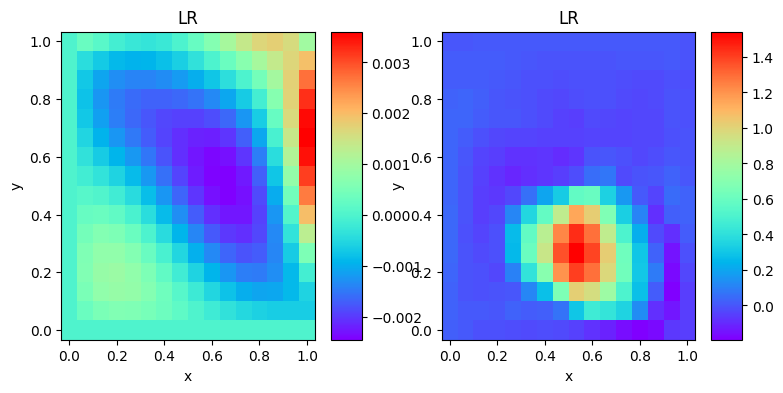

In [33]:
fig = plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.pcolormesh(x_low, y_low, residual.cpu().data.numpy()[3], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,2,2)
plt.pcolormesh(x_low, y_low, out.cpu().data.numpy()[0][0][3], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
# cbar.mappable.set_clim(-0.8,0.4)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [15]:
# Parameters for Langevin dynamics
s = 0.00001
K = 1500

x = torch.tensor(w_low).to(torch.float32).to(device)
z = F.interpolate(x.reshape(1,1,N_low,N_low,N_low),(N_high,N_high,N_high),mode='trilinear').reshape(N_high,N_high,N_high)
z = z.clone().detach().requires_grad_(True)
chains_evolution = []

startTime = time.time()

for i in range(K):
    # Grad log-likelihood
    # observation = torch.spmm(H,z.reshape(N_high*N_high,1)).reshape(N_low,N_low)
    downscaled = F.interpolate(z.reshape(1,1,N_high,N_high,N_high),(N_low,N_low,N_low)).reshape(N_low,N_low,N_low)
    x_hat = downscaled + G(downscaled.reshape(1,1,N_low,N_low,N_low)).reshape(N_low,N_low,N_low)
    log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**3),(x-x_hat).reshape(N_low**3,1)))
    grad_ll = torch.autograd.grad(log_likelihood, z)[0]
    
    # Grad prior
    difference = A_high.dot(z.cpu().data.numpy().reshape(N_high**3,1)) - b_high.reshape(N_high**3,1)
    grad_log_prior = (- operator.dot(difference)).reshape(N_high,N_high,N_high)
    grad_log_prior = torch.tensor(grad_log_prior).to(torch.float32).to(device)
    
    # Random noise term
    W = torch.randn(*[N_high,N_high,N_high]).to(device)
    # random = torch.matmul(G_sqrt,W.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W
    
    if i > K-10:
        chains_evolution.append(z.cpu().data.numpy())  
    
endTime = time.time() 
print(endTime-startTime)

112.30922436714172


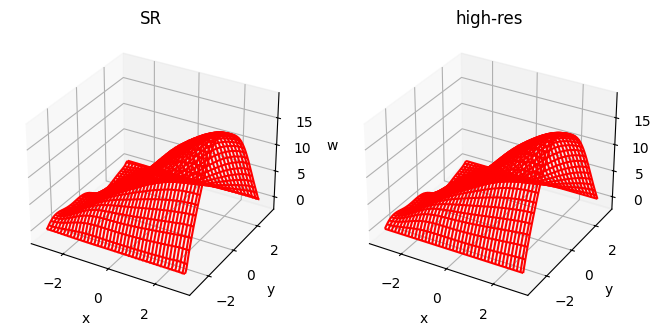

In [34]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_high, y_high)
ax1.plot_wireframe(X, Y, z.cpu().data.numpy(),color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('SR')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, w_high,color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

In [35]:
error1 = abs(w_high - np.mean(chains_evolution,axis=0))
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)

SR L2 Error: 0.0428429093622334


### Upscale by 6

In [346]:
N_low = 21
N_high = 121
scale = 6
a,b,c = 8,5,5

h_low = 1/(N_low-1)
x_low = np.arange(0,1.0001,h_low)
y_low = np.arange(0,1.0001,h_low)

h_high = 1/(N_high-1)
x_high = np.arange(0,1.0001,h_high)
y_high = np.arange(0,1.0001,h_high)

In [116]:
w_low, r_low, A_low, x_low, y_low = generate_data(N_low,a,b,c)
w_high, r_high, A_high, x_high, y_high = generate_data(N_high,a,b,c)

In [117]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for prior variance
prior_sigma = 0.002
ll_sigma = 0.003

In [123]:
G = np.eye(N_high**2) * prior_sigma**2
G_inverse = np.eye(N_high**2) * (1/prior_sigma**2)

# Turn matrices to tensors
G = torch.tensor(G).to(torch.float32).to(device)
G_inverse = torch.tensor(G_inverse).to(torch.float32).to(device)
A_high = torch.tensor(create_A(N_high)).to(torch.float32).to(device)
b_high = torch.tensor(create_forcing_term(N_high,a,b,c)).to(torch.float32).to(device)

# Store sparse matrices as sparse tensor
A_high = A_high.to_sparse()
G = G.to_sparse()
G_inverse = G_inverse.to_sparse()
operator = torch.spmm(A_high.T,G_inverse).to(device)

In [124]:
x = torch.tensor(w_low).to(torch.float32).to(device)
posterior_initial = torch.randn(*[N_high,N_high]).to(torch.float32).to(device)

In [143]:
G = ResidualLearning().to(device)
G.load_state_dict(torch.load('models/model3/21_121/lr0.005_gamma0.5_stepsize30_K10000/ckpt/current_epoch.pth')['netG'])
# G.load_state_dict(torch.load('models/residual_from_low/21_81/lr0.01_gamma0.5/ckpt/best_model.pth')['netG'])

<All keys matched successfully>

In [144]:
w_high_tensor = torch.tensor(w_high).to(torch.float32).to(device)
w_low_tensor = torch.tensor(w_low).to(torch.float32).to(device)
downscaled = F.interpolate(w_high_tensor.reshape(1,1,N_high,N_high),(N_low,N_low)).reshape(N_low,N_low)
out = G(downscaled.reshape(1,N_low,N_low))
residual = w_low_tensor-downscaled

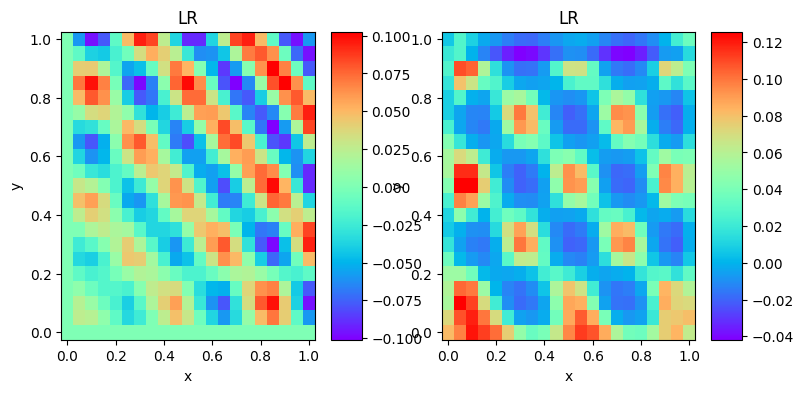

In [145]:
fig = plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.pcolormesh(x_low, y_low, residual.cpu().data.numpy(), cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,2,2)
plt.pcolormesh(x_low, y_low, out.cpu().data.numpy()[0], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [146]:
# Parameters for Langevin dynamics
s = 0.0004
ll_sigma = 0.002

z = posterior_initial
chains_evolution = []
z = z.clone().detach().requires_grad_(True)
for i in range(5000):
    # Grad log-likelihood
    # observation = torch.spmm(H,z.reshape(N_high*N_high,1)).reshape(N_low,N_low)
    downscaled = F.interpolate(z.reshape(1,1,N_high,N_high),(N_low,N_low)).reshape(N_low,N_low)
    x_hat = downscaled + G(downscaled.reshape(1,N_low,N_low)).reshape(N_low,N_low)
    log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**2),(x-x_hat).reshape(N_low**2,1)))
    grad_ll = torch.autograd.grad(log_likelihood, z)[0]
    # grad_log_likelihood = torch.matmul(G,grad_ll.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    # Grad prior
    difference = torch.spmm(A_high,z.reshape(N_high*N_high,1)) - b_high.reshape(N_high**2,1)
    # log_prior = - 0.5 * difference.T @ G_inverse @ difference
    # grad_log_prior = torch.autograd.grad(log_prior, z)[0]
    grad_log_prior = (- torch.spmm(operator,difference)).reshape(N_high,N_high)
    
    # Random noise term
    W = torch.randn(*[N_high,N_high]).to(device)
    # random = torch.matmul(G_sqrt,W.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W
    # chains_evolution.append(z.cpu().data.numpy())   

KeyboardInterrupt: 

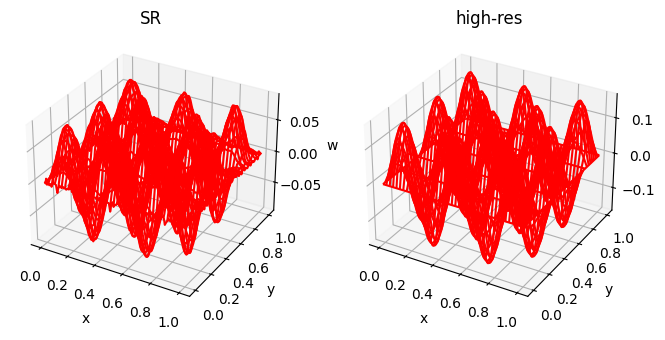

In [129]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_high, y_high)
ax1.plot_wireframe(X, Y, z.cpu().data.numpy(),color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('SR')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, w_high,color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

In [130]:
error1 = abs(w_high - z.cpu().data.numpy())
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)

SR L2 Error: 0.0023469960727095147
